In [1]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import vgg19
from tensorflow.keras import backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
import PIL.Image
from PIL import Image
import scipy
import time

In [8]:
target_img = '/Users/fi000980702/Desktop/soccer_scaled.jpg'      # Path to the image we want to transform
style_ref_img = '/Users/fi000980702/Desktop/VvC_style_ref_scaled.jpg'   # Path to the style reference image

width, height = load_img(target_img).size
img_height = 400
img_width = int(width*img_height/height)

In [9]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

def deprocess_image(x):
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

The style reference and target image are static, and thus defined using ```K.constant```, while the values contained in the placeholder of the generated image will change over time.

In [10]:
target_image = K.constant(preprocess_image(target_img))
style_reference_image = K.constant(preprocess_image(style_ref_img))

combination_image = K.placeholder((1,                            # Placeholder for the generated image
                                   img_height, 
                                   img_width, 
                                   3)) 

input_tensor = K.concatenate([target_image,                      # Combine the 3 images into a single batch
                              style_reference_image,
                              combination_image], axis=0)

model = vgg19.VGG19(input_tensor=input_tensor,                   # Build VGG19 network with the 3 images as input.
                    weights='imagenet',
                    include_top=False)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Define the content loss, meant to make sure that the top layer of the VGG19 convnet will have a similar view of the target image and the generated image:

In [11]:
def content_loss(base, combination):
    return K.sum(K.square(combination-base))

Define the style loss. It leverages an auxiliary function to compute the Gram matrix of an input matrix, i.e. a map of the correlations found in the original feature matrix.

In [12]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram


def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_height*img_width
    return K.sum(K.square(S-C))/(4.*(channels**2)*(size**2))

To these two loss components, we add a third one, the "total variation loss". It is meant to encourage spatial continuity in the generated image, thus avoiding overly pixelated results, a regularization loss so to speak.

In [13]:
def total_variation_loss(x):  
    a = K.square(
        x[:, :img_height-1, :img_width-1, :] - x[:, 1:, :img_width-1, :])
    b = K.square(
        x[:, :img_height-1, :img_width-1, :] - x[:, :img_height-1, 1:, :])
    return K.sum(K.pow(a+b, 1.25))

The loss that we minimize is a weighted average of these three losses. To compute the content loss, we only leverage one top layer, the block5_conv2 layer, while for the style loss we use a list of layers than spans both low-level and high-level layers. We add the total variation loss at the end.

Depending on the style reference image and content image you are using, you will likely want to tune the content_weight coefficient, the contribution of the content loss to the total loss. A higher content_weight means that the target content will be more recognizable in the generated image.

* We create a dictionary that maps layer names to activation tensors
* We define layers for content and style losses
* We define weights for the weighted average of the loss components
* We define a scalar variable in which we add the layer contributions

In [14]:
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers]) 
content_layer = 'block5_conv2'
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

total_variation_weight = 1e-4
style_weight = 1.
content_weight = 0.025

loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss = loss+content_weight*content_loss(target_image_features,
                                      combination_features)
for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss = loss+(style_weight / len(style_layers))*sl
loss = loss+total_variation_weight*total_variation_loss(combination_image)

In [15]:
grads = K.gradients(loss, combination_image)[0]
fetch_loss_and_grads = K.function([combination_image], [loss, grads])

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, img_height, img_width, 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

* Run scipy-based optimization (L-BFGS) over the pixels of the generated image
* so as to minimize the neural style loss.
* This is our initial state: the target image.
* Note that `scipy.optimize.fmin_l_bfgs_b` can only process flat vectors.

In [16]:
result_prefix = 'style_transfer_result'
iterations = 12

x = preprocess_image(target_img)
x = x.flatten()
for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x, fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))
    
img = x.copy().reshape((img_height, img_width, 3))
im = Image.fromarray(deprocess_image(img))
im.save('SoccerVGG19_nt.jpeg')

Start of iteration 0
Current loss value: 1921825300.0
Iteration 0 completed in 445s
Start of iteration 1
Current loss value: 581904400.0
Iteration 1 completed in 427s
Start of iteration 2
Current loss value: 349542500.0
Iteration 2 completed in 425s
Start of iteration 3
Current loss value: 265658580.0
Iteration 3 completed in 451s
Start of iteration 4
Current loss value: 214137100.0
Iteration 4 completed in 493s
Start of iteration 5
Current loss value: 178187040.0
Iteration 5 completed in 540s
Start of iteration 6
Current loss value: 150387100.0
Iteration 6 completed in 433s
Start of iteration 7
Current loss value: 132943180.0
Iteration 7 completed in 418s
Start of iteration 8
Current loss value: 115644344.0
Iteration 8 completed in 422s
Start of iteration 9
Current loss value: 104990696.0
Iteration 9 completed in 421s
Start of iteration 10
Current loss value: 91611760.0
Iteration 10 completed in 469s
Start of iteration 11
Current loss value: 85047820.0
Iteration 11 completed in 429s


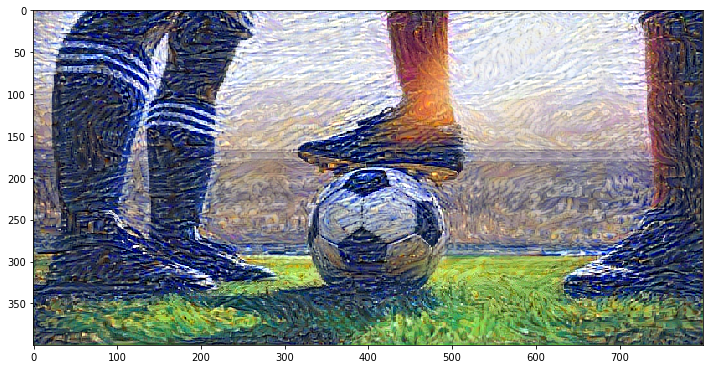

In [17]:
fig, ax = plt.subplots(figsize=(12, 8))
# Content image
ax.imshow(load_img(target_img, target_size=(img_height, img_width)))
# Style image
ax.imshow(load_img(style_ref_img, target_size=(img_height, img_width)))
# Generate image
ax.imshow(im)
plt.show()